# LTV Analysis - Exploratory data analysis
Author: Ricardo Raspini Motta

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import lifelines

from sklearn.model_selection import GridSearchCV

In [2]:
base = catalog.load("base")
xs = catalog.load("xs")

[11/28/23 00:08:13] INFO     Loading data from 'base' (CSVDataSet)...                           ]8;id=210379;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=169096;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'xs' (CSVDataSet)...                             ]8;id=718729;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=191029;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

### Base table

In [3]:
base

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
0,37d76d441d,2020-12-01,NaN,product_a,12.1775,channel_a,55+,iOS
1,cdc1327d79,2022-05-09,NaN,product_a,12.4575,channel_a,18-24,iOS
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android
3,b0c703a998,2020-05-21,NaN,product_a,12.0475,channel_b,35-39,Android
4,0276bcc756,2021-04-15,NaN,product_c,15.7700,channel_b,35-39,Android
...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12,NaN,product_a,12.6825,channel_a,45-49,iOS
102619,58ce7b5a49,2022-11-27,NaN,product_b,13.6975,channel_a,45-49,iOS
102620,4744036910,2022-07-22,NaN,product_a,12.1925,channel_a,45-49,iOS
102621,ca58e4734d,2021-07-16,NaN,product_a,13.7525,channel_a,50-54,Android


In [4]:
base["age_bucket"].value_counts()


age_bucket
30-34        22731
25-29        22346
35-39        14100
55+          11560
18-24        10458
40-44         9266
45-49         6298
50-54         5810
undefined       54
Name: count, dtype: int64

In [5]:
base["product"].value_counts()


product
product_a    82084
product_c    15921
product_b     4618
Name: count, dtype: int64

In [6]:
base["channel"].value_counts()


channel
channel_b    56057
channel_a    46566
Name: count, dtype: int64

In [7]:
base["commission"].describe()


count    102623.000000
mean         13.500813
std           3.990741
min          10.000000
25%          11.905000
50%          12.557500
75%          13.447500
max         136.407500
Name: commission, dtype: float64

In [8]:
base["operating_system"].value_counts()


operating_system
Android      48405
iOS          47520
iPadOS         797
iPhone OS       18
Name: count, dtype: int64

In [9]:
base.loc[:, "operating_system"] = base["operating_system"].replace({"iPadOS": "iOS", "iPhone OS": "iOS"})

### Cross selling table

In [10]:
xs

,user_id,product,commission,date
0,ccc05d82e1,product_y,499.6000,2022-08-05
1,77a488f223,product_y,821.2950,2022-10-20
2,e717cb5a0b,product_y,1215.0350,2023-01-19
3,1e9ca78b5b,product_y,413.1800,2022-12-20
4,eee1f85c5c,product_y,354.4475,2022-10-06
...,...,...,...,...
1313,b46d770837,product_y,579.6650,2022-11-01
1314,af3b28aac0,product_y,418.3700,2022-10-11
1315,623b0fe810,product_x,1269.0025,2022-06-30
1316,3cc2642221,product_y,377.0550,2022-09-22


#### All users are unique in the base table

In [11]:
len(base["user_id"].unique()) == len(base)

True

#### That is not the same at the Cross Selling table

In [12]:
len(xs["user_id"].unique()) == len(xs)

False

#### Looking for the most frequent client

In [13]:
xs["user_id"].value_counts().head(1)


user_id
995528dadd    5
Name: count, dtype: int64

In [14]:
base.loc[base["user_id"]=="995528dadd"]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
22280,995528dadd,2022-04-24,NaN,product_a,12.925,channel_b,30-34,Android


In [15]:
xs.loc[xs["user_id"]=="995528dadd"]

,user_id,product,commission,date
163,995528dadd,product_y,262.00,2022-12-30
164,995528dadd,product_y,1723.60,2022-05-05
165,995528dadd,product_y,195.46,2022-05-05
166,995528dadd,product_y,262.00,2022-12-30
167,995528dadd,product_y,244.60,2023-02-08


## Commission per product

In [16]:
def get_commission_per_product(df):
    comission_per_product = df.groupby("product").agg({"commission": ["sum","count"]})
    comission_per_product.columns = list(map('_'.join, comission_per_product.columns.values))
    
    comission_per_product.loc[:,"commission_per_unit"] = comission_per_product["commission_sum"] / comission_per_product["commission_count"]
    return comission_per_product

In [17]:
comission_per_product_base = get_commission_per_product(base)
comission_per_product_xs = get_commission_per_product(xs)
comission_per_product = pd.concat([
        comission_per_product_base,
        comission_per_product_xs
    ],
     ignore_index=False).reset_index()

#### The table below shows that the commision per unit is far bigger in the cross selling products.
That said, the cross selling brings a big financial opportunity

In [18]:
comission_per_product

,product,commission_sum,commission_count,commission_per_unit
0,product_a,1.014396e+06,82084,12.358022
1,product_b,6.470865e+04,4618,14.012268
2,product_c,3.063894e+05,15921,19.244357
3,product_x,7.797592e+04,79,987.036930
4,product_y,6.511947e+05,976,667.207677


In [19]:
xs = pd.merge(
    xs,
    pd.get_dummies(xs["product"]),
    left_index=True,
    right_index=True,
)

grouped_xs = xs.groupby("user_id").sum()[["commission", "product_x", "product_y"]].reset_index()

df = pd.merge(
    base,
    grouped_xs,
    on="user_id",
    how="left",
    suffixes=["_base", "_xs"]
)

datetime_cols = ["customer_churned_at", "customer_started_at"]
for col in datetime_cols:
    df.loc[:, col] = pd.to_datetime(df[col], errors="coerce", utc=False)

df.loc[:,"is_churn"] = ~df["customer_churned_at"].isna()

In [20]:
df

,user_id,customer_started_at,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_churn
0,37d76d441d,2020-12-01 00:00:00,NaT,product_a,12.1775,channel_a,55+,iOS,NaN,NaN,NaN,False
1,cdc1327d79,2022-05-09 00:00:00,NaT,product_a,12.4575,channel_a,18-24,iOS,NaN,NaN,NaN,False
2,fac8c03aa8,2021-11-20 00:00:00,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,NaN,NaN,NaN,True
3,b0c703a998,2020-05-21 00:00:00,NaT,product_a,12.0475,channel_b,35-39,Android,NaN,NaN,NaN,False
4,0276bcc756,2021-04-15 00:00:00,NaT,product_c,15.7700,channel_b,35-39,Android,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12 00:00:00,NaT,product_a,12.6825,channel_a,45-49,iOS,NaN,NaN,NaN,False
102619,58ce7b5a49,2022-11-27 00:00:00,NaT,product_b,13.6975,channel_a,45-49,iOS,NaN,NaN,NaN,False
102620,4744036910,2022-07-22 00:00:00,NaT,product_a,12.1925,channel_a,45-49,iOS,NaN,NaN,NaN,False
102621,ca58e4734d,2021-07-16 00:00:00,NaT,product_a,13.7525,channel_a,50-54,Android,NaN,NaN,NaN,False


In [21]:
df.loc[:,"is_xs"] = np.where(df[["product_x", "product_x"]].fillna(0).sum(axis=1) >0, 1, 0)

#### Churn rates in relation with categorical values

In [22]:
df.groupby("product").agg({"is_churn": "mean"})

,is_churn
product,
product_a,0.363749
product_b,0.295366
product_c,0.460775


In [23]:
df.groupby("channel").agg({"is_churn": "mean"})

,is_churn
channel,
channel_a,0.405983
channel_b,0.350590


In [24]:
df.groupby("operating_system").agg({"is_churn": "mean"})

,is_churn
operating_system,
Android,0.406115
iOS,0.316624


In [25]:
df.groupby("age_bucket").agg({"is_churn": "mean"})

,is_churn
age_bucket,
18-24,0.375311
25-29,0.343820
30-34,0.368132
35-39,0.413617
40-44,0.432981
45-49,0.410924
50-54,0.356282
55+,0.349221
undefined,0.796296


In [26]:
df.groupby("is_xs").agg({"is_churn": "mean"})

,is_churn
is_xs,
0,0.376038
1,0.041667


In [27]:
df.loc[:, "customer_started_at"] = pd.to_datetime(df["customer_started_at"])
df.loc[:, "is_churn"] = ~df["customer_churned_at"].isna()
df.loc[df["is_churn"], "days_to_churn"] = (
    pd.to_datetime(df.loc[df["is_churn"], "customer_churned_at"])
    .subtract(pd.to_datetime(df.loc[df["is_churn"], "customer_started_at"]))
    .dt.days
)
df = df.set_index("customer_started_at")

plot_users = df.groupby(pd.Grouper(freq="M")).agg(
    {
        "user_id" : "count",
        "is_xs": "sum",
        "product_x": "sum",
        "product_y": "sum",
    }
)

## Sales per time

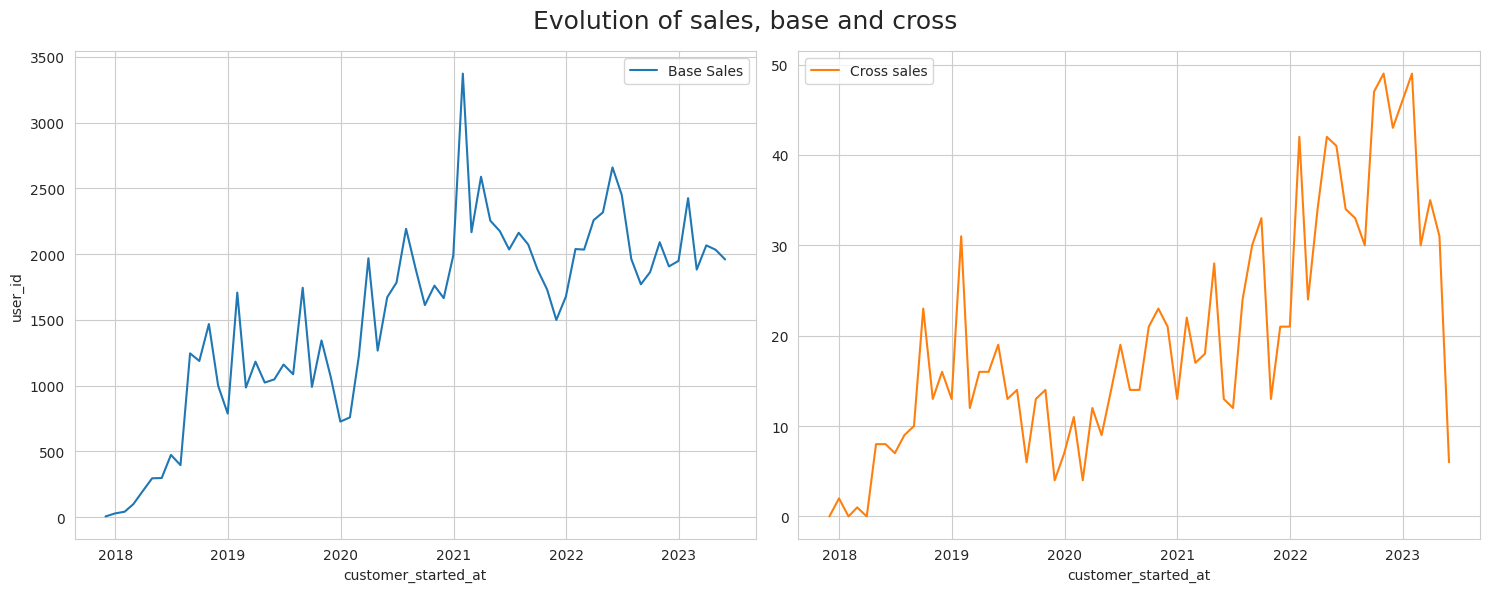

In [28]:
sns.set_style("whitegrid")
palette = sns.color_palette()
fig,axs = plt.subplots(1,2, figsize = (15,6))
sns.lineplot(plot_users["user_id"], ax = axs[0], color = palette[0], label="Base Sales")
sns.lineplot(plot_users["product_x"] + plot_users["product_y"], ax = axs[1], color = palette[1], label="Cross sales")
plt.suptitle("Evolution of sales, base and cross", fontsize=18)
plt.tight_layout()
plt.show()

## Churn related to numerical variables

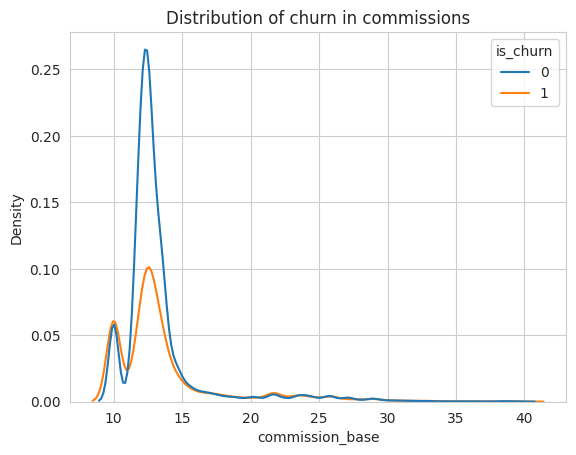

In [29]:
inf_lim, sup_lim = 0,40
col_to_plot = "commission_base"
dataplot = df.loc[(df[col_to_plot]<=sup_lim) & (df[col_to_plot]>=inf_lim)]
sns.kdeplot(data = dataplot, x= col_to_plot, hue=dataplot["is_churn"].astype(int))
plt.title("Distribution of churn in commissions")
plt.show()

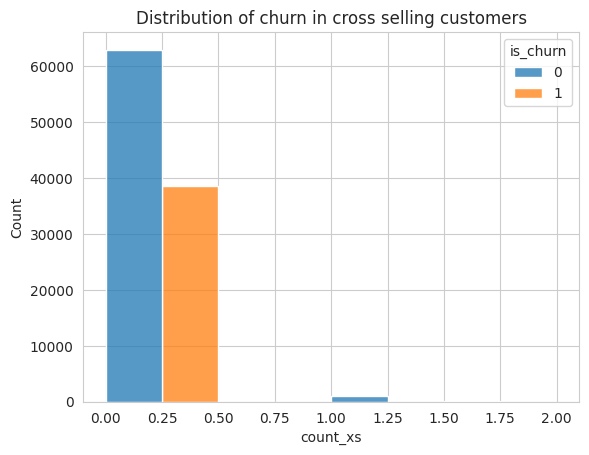

In [30]:
df.loc[:, "count_xs"] = df["product_x"].fillna(0) + df["product_y"].fillna(0)
inf_lim, sup_lim = 0,2
col_to_plot = "count_xs"
dataplot = df.loc[(df[col_to_plot]<=sup_lim) & (df[col_to_plot]>=inf_lim)]
sns.histplot(data = dataplot, x= col_to_plot, hue=dataplot["is_churn"].astype(int), binwidth=0.5, multiple="dodge")
plt.title("Distribution of churn in cross selling customers")
plt.show()

In [31]:
df = df.reset_index()

actual_date = max(
    df["customer_churned_at"].dropna().max(),
    df["customer_started_at"].dropna().max(),
)
df.loc[df["days_to_churn"] < 0, "days_to_churn"] = 0
df.loc[~df["is_churn"], "days_to_churn"] = (
    actual_date - pd.to_datetime(df.loc[~df["is_churn"], "customer_started_at"])
).dt.days
df.loc[:, "months_as_client"] = df.loc[:, "days_to_churn"] /30

df.loc[:, "LTV"] = (df.loc[:, "months_as_client"] * df["commission_base"]) + df["commission_xs"].fillna(0)

In [32]:
df.loc[df["is_churn"], "days_to_churn"] = pd.to_datetime(df.loc[df["is_churn"],"customer_churned_at"]).subtract(df.loc[df["is_churn"] ,"customer_started_at"]).dt.days


<Axes: xlabel='days_to_churn', ylabel='Count'>

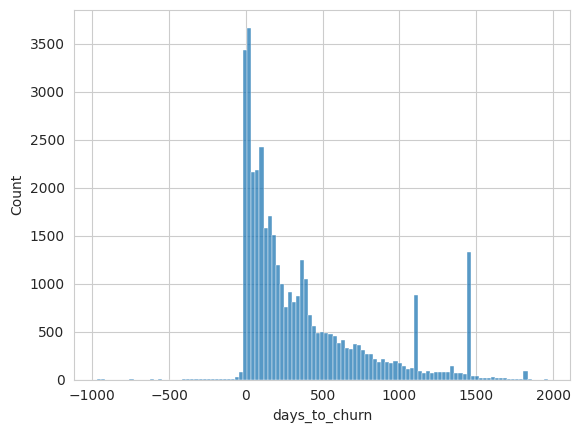

In [33]:
sns.histplot(df.loc[df["is_churn"], "days_to_churn"])

In [34]:
users_churn_negative = df.loc[df.loc[:, "days_to_churn"] <0]["user_id"].to_list()

#### There is also probably the need to investigate why those 1559 users have churn dates after their starting date

In [35]:
base.loc[base["user_id"].isin(users_churn_negative)]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
24,2be74ed2d0,2020-11-01,2020-10-21,product_c,11.7700,channel_b,30-34,iOS
138,e2a48eefd4,2019-08-19,2019-08-18,product_a,12.5575,channel_a,30-34,Android
188,248b96ed87,2022-02-10,2022-02-09,product_b,17.7700,channel_b,30-34,iOS
235,fd42d75ac6,2020-05-03,2020-05-02,product_a,11.5225,channel_b,40-44,iOS
239,22fa81cbc6,2019-08-09,2019-08-08,product_a,12.5575,channel_a,25-29,Android
...,...,...,...,...,...,...,...,...
102289,e3d3ba4a43,2022-12-24,2022-12-23,product_a,13.4475,channel_b,25-29,iOS
102298,5a957c1a3f,2019-11-17,2019-11-16,product_a,12.5575,channel_a,18-24,iOS
102458,32907bbb05,2021-03-11,2021-03-10,product_c,15.7050,channel_b,35-39,iOS
102528,6d0f098e73,2022-09-29,2022-09-12,product_a,12.4575,channel_a,25-29,iOS


#### The LTV seems to be a lot higher for clients that buys on Cross-selling.

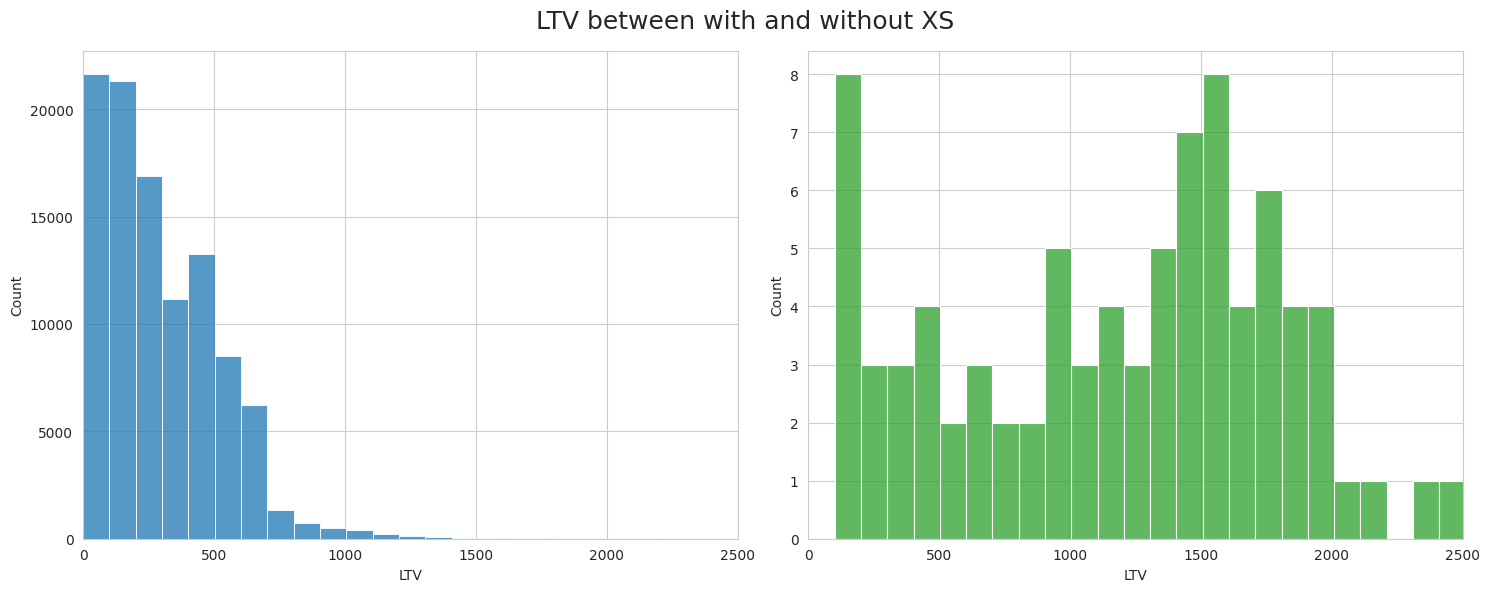

In [36]:
sns.set_style("whitegrid")
palette = sns.color_palette()
fig,axs = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df.loc[~df["is_xs"].astype(bool),"LTV"], ax = axs[0], color = palette[0], label="Non XS",binwidth=100)
sns.histplot(df.loc[df["is_xs"].astype(bool),"LTV"], ax = axs[1], color = palette[2], label="XS",binwidth=100)
axs[0].set_xlim(0,2500)
axs[1].set_xlim(0,2500)

plt.suptitle("LTV between with and without XS", fontsize=18)
plt.tight_layout()
plt.show()

In [37]:
df

,customer_started_at,user_id,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_churn,is_xs,days_to_churn,count_xs,months_as_client,LTV
0,2020-12-01,37d76d441d,NaT,product_a,12.1775,channel_a,55+,iOS,NaN,NaN,NaN,False,0,1126.0,0.0,37.533333,457.062167
1,2022-05-09,cdc1327d79,NaT,product_a,12.4575,channel_a,18-24,iOS,NaN,NaN,NaN,False,0,602.0,0.0,20.066667,249.980500
2,2021-11-20,fac8c03aa8,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,NaN,NaN,NaN,True,0,407.0,0.0,13.566667,293.887917
3,2020-05-21,b0c703a998,NaT,product_a,12.0475,channel_b,35-39,Android,NaN,NaN,NaN,False,0,1320.0,0.0,44.000000,530.090000
4,2021-04-15,0276bcc756,NaT,product_c,15.7700,channel_b,35-39,Android,NaN,NaN,NaN,False,0,991.0,0.0,33.033333,520.935667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,2021-02-12,7df1a34a0d,NaT,product_a,12.6825,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,1053.0,0.0,35.100000,445.155750
102619,2022-11-27,58ce7b5a49,NaT,product_b,13.6975,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,400.0,0.0,13.333333,182.633333
102620,2022-07-22,4744036910,NaT,product_a,12.1925,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,528.0,0.0,17.600000,214.588000
102621,2021-07-16,ca58e4734d,NaT,product_a,13.7525,channel_a,50-54,Android,NaN,NaN,NaN,False,0,899.0,0.0,29.966667,412.116583


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_correlation_heatmap(dataframe):
    corr = dataframe.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation matrix

As expected, LTV is highly correlated with the cross-selling variable. 
Out of that, there is no too strong correlation to show. 

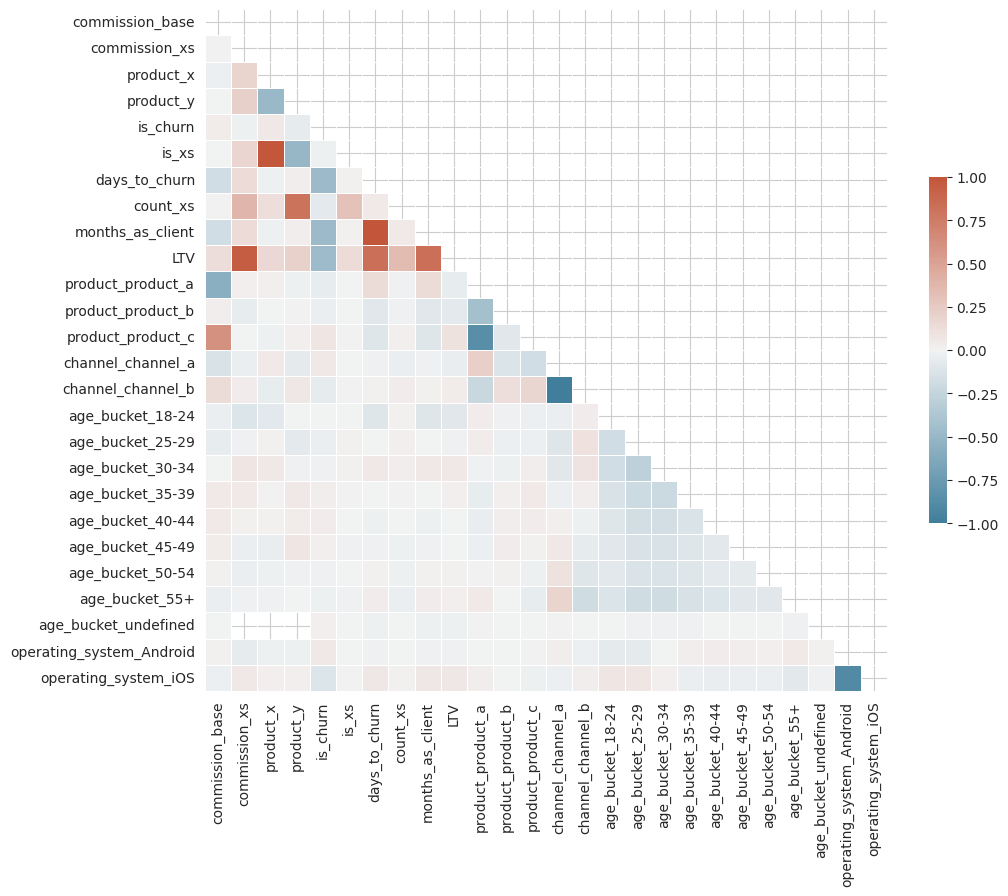

In [39]:
plot_correlation_heatmap(
    pd.get_dummies(
        df.drop(columns=["customer_started_at", "user_id", "customer_churned_at"]))
)

In [40]:
meanprops={
    "marker":"o",
    "markerfacecolor":"white", 
    "markeredgecolor":"black",
    "markersize":"10"
}

### LTV Across categorical variables

The product base C has the biggest LTV, followed by product A.

<Axes: xlabel='product', ylabel='LTV'>

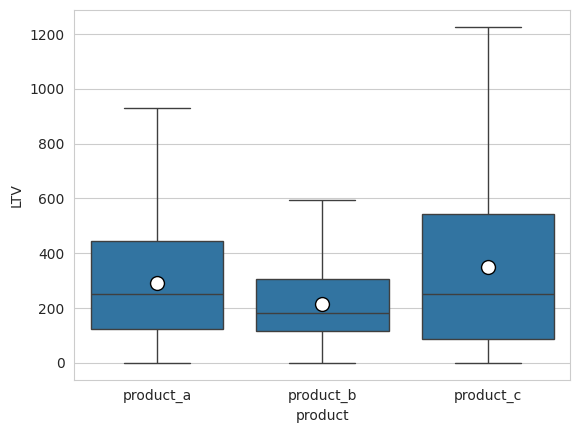

In [41]:
sns.boxplot(data=df.sort_values(by="product"), y="LTV", x="product", showfliers=False, showmeans=True, meanprops=meanprops)

#### Channel does not show a big difference in the mean, but the channel b is a lot more spread.

<Axes: xlabel='channel', ylabel='LTV'>

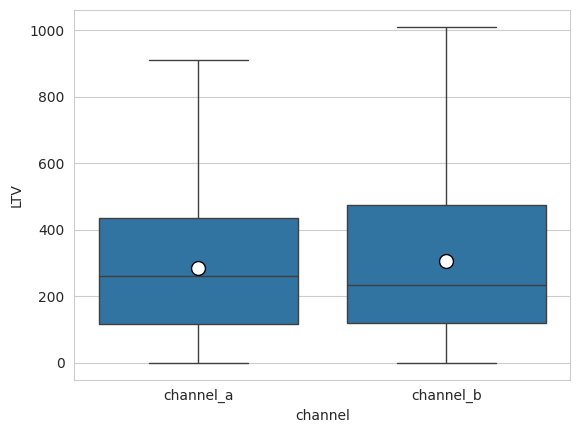

In [42]:
sns.boxplot(data=df, y="LTV", x="channel", showfliers=False, showmeans=True, meanprops=meanprops)

#### We can see a peak in the 30-34 age group. After that, there is some sort of a plateau. This indicates that this should be a target group.

<Axes: xlabel='age_bucket', ylabel='LTV'>

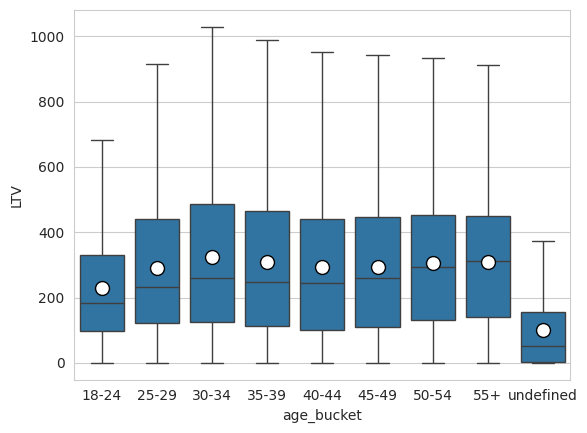

In [43]:
sns.boxplot(data=df.sort_values(by="age_bucket"), y="LTV", x="age_bucket", showfliers=False, showmeans=True, meanprops=meanprops)

#### The operating system does not seem to have strong correlation with LTV

<Axes: xlabel='operating_system', ylabel='LTV'>

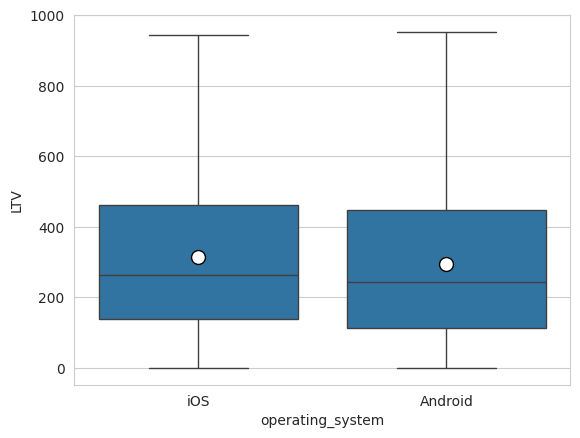

In [44]:
sns.boxplot(data=df, y="LTV", x="operating_system", showfliers=False, showmeans=True, meanprops=meanprops)